# Analysing Causal Effects for Red Wine Quality
### Causal Question: What is the Causal Effect of Alcohol on Quality?
### **Causal ML Summer 2022 NEU**

**Darshil Patel**

In [ ]:
!pip install dowhy igraph factor_analyzer lingam econml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached factor_analyzer-0.4.0-py3-none-any.whl
  Using cached econml-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)


In [ ]:
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.causal_refuters as causal_refuters
import dowhy.datasets
import dowhy.api

# making and drawing graphs
import graphviz
import networkx as nx
import matplotlib.pyplot as plt
from statsmodels.api import OLS

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## The Data

For this example, we will be using a wine quality dataset from CMU that includes essential ground truth causal information. This dataset contains 12 features inclusing the output feature.

1.  fixed acidity
2.  volatile acidity
3.  citric acid
4.  residual sugar
5.  chlorides
6.  free sulfur dioxide
7.  total sulfur dioxide
8.  density
9.  pH
10.  sulphates
11.  alcohol
12.  quality (score between 0 and 10) **Output variable**

We know from external sources that the ground truth DAG must have at least edges from both `alcohol` and `total_sulfur_dioxide` to quality. We also know that edges between the features are possible.

In [ ]:
# Read in the Red Wine Quality data set from repo
red_data = pd.read_csv("https://raw.githubusercontent.com/zygmuntz/wine-quality/master/winequality/winequality-red.csv", sep=None)

# Display the first 5 elements of the data
red_data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### 1. Modeling

First we run a causal discovery algorithm to get an idea of the causal relationships in our data generating process, then we make our custom causal dag to model our data.

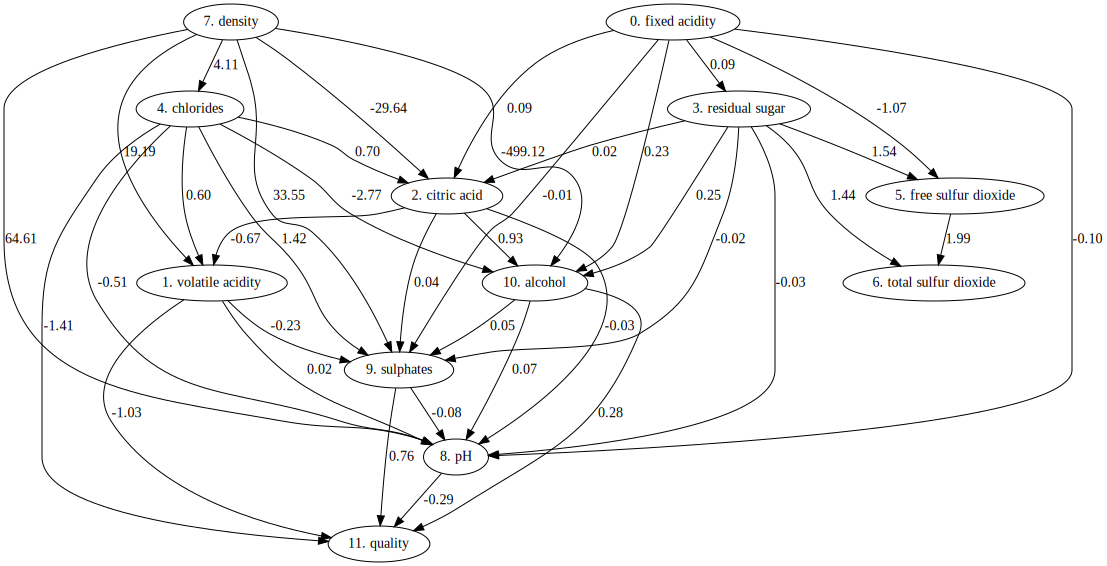

In [ ]:
import graphviz
import lingam
from lingam.utils import make_prior_knowledge

def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d

pk = make_prior_knowledge(
    n_variables=len(red_data.columns),
    sink_variables=[11])

model = lingam.DirectLiNGAM(prior_knowledge=pk)
model.fit(red_data)
labels = [f'{i}. {col}' for i, col in enumerate(red_data.columns)]
graph = make_graph(model.adjacency_matrix_, labels)
graph

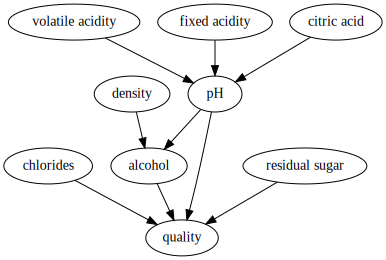

In [170]:
# Create the Causal DAG
causal_dag = graphviz.Digraph('DAG')

causal_dag.node('quality')
causal_dag.node('chlorides')
causal_dag.node('density')
causal_dag.node('volatile acidity')
causal_dag.node('alcohol')
causal_dag.node('residual sugar')
causal_dag.node('fixed acidity')
causal_dag.node('citric acid')
causal_dag.node('pH')


causal_dag.edges([
           ('fixed acidity', 'pH'),
           ('volatile acidity', 'pH'),
           ('citric acid', 'pH'),
           ('pH', 'alcohol'),
           ('density', 'alcohol'),
           ('chlorides', 'quality'),
           ('pH', 'quality'),
           ('residual sugar', 'quality'),
           ('alcohol', 'quality'),
           ])

causal_dag

In [171]:
is_treatment = False

causal_dag_final = causal_dag.source.replace('DAG', '').replace('\n', ';').replace('\t', '').replace('{;q', '{q')

model = CausalModel(
    data = red_data,
    graph=causal_dag_final,
    treatment = ['alcohol'],
    outcome = ['quality'])

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


### 2. Identify

Check whether the target quantity can be estimated given the observed variables.


In [172]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                              
──────────(Expectation(quality|pH))
d[alcohol]                         
Estimand assumption 1, Unconfoundedness: If U→{alcohol} and U→quality then P(quality|alcohol,pH,U) = P(quality|alcohol,pH)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(quality, [density])*Derivative([alcohol], [density])**(
-1))
Estimand assumption 1, As-if-random: If U→→quality then ¬(U →→{density})
Estimand assumption 2, Exclusion: If we remove {density}→{alcohol}, then ¬({density}→quality)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### 3. Estimation

In [173]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['chlorides', 'residual sugar']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                              
──────────(Expectation(quality|pH))
d[alcohol]                         
Estimand assumption 1, Unconfoundedness: If U→{alcohol} and U→quality then P(quality|alcohol,pH,U) = P(quality|alcohol,pH)

## Realized estimand
b: quality~alcohol+pH+alcohol*chlorides+alcohol*residual sugar
Target units: ate

## Estimate
Mean value: 0.37762785614028926
### Conditional Estimates
__categorical__chlorides  __categorical__residual sugar
(0.011, 0.067]            (0.899, 1.8]                     0.382635
                          (1.8, 2.1]                       0.381675
                          (2.

### 4. Refutation

Adding a random cause should not change the effect of the treatment.

Using a placebo should cause the treatment to have close to no effect.

In [174]:
refute_results_random = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")
print(refute_results_random)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['chlorides', 'residual sugar']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['chlorides', 'residual sugar']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['chlorides', 'residual sugar']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['chlorides', 'residual sugar']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_uni

In [175]:
refute_results_placebo = model.refute_estimate(identified_estimand, estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['chlorides', 'residual sugar']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['chlorides', 'residual sugar']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['chlorides', 'residual sugar']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['chlorides', 'residual sugar']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_uni

# Conclusion

From our observations of causal effects on alcohol for our quality outcome, we found that acidity had a measurable effect. We find that the quality wine changes by approx 0.377 due to the alcohol content. This causal relationship is tested for robustness by our refutation tests for a random cause and placebo which both succeeded in validating the model.